In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_recall_curve, classification_report,
                             confusion_matrix, recall_score)
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
np.random.seed(42)

print("Memuat dataset...")
train_df = pd.read_csv('dataset_findIt/train.csv')
test_df = pd.read_csv('dataset_findIt/test.csv')
target_df = pd.read_csv('dataset_findIt/target.csv')


Memuat dataset...


In [3]:
# data prepocessing
def advanced_preprocessing(train_df, test_df):
    test_ids = test_df['id'].copy() if 'id' in test_df.columns else None
    train_df = train_df.drop(columns=['id']) if 'id' in train_df.columns else train_df
    test_df = test_df.drop(columns=['id']) if 'id' in test_df.columns else test_df

    def impute_data(df):
        numeric_cols = []
        cat_cols = []
        for col in df.columns:
            numeric_vals = pd.to_numeric(df[col], errors='coerce')
            if not numeric_vals.isna().all():
                df[col] = numeric_vals
                numeric_cols.append(col)
            else:
                cat_cols.append(col)
        if numeric_cols:
            num_imputer = SimpleImputer(strategy='median')
            df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
        if cat_cols:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
        return df, numeric_cols, cat_cols

    train_df, numeric_cols, cat_cols = impute_data(train_df)
    test_df, _, _ = impute_data(test_df)
    unique_features = set(numeric_cols)

    for df in [train_df, test_df]:
        skewed_cols = [col for col in ['downloads', 'size', 'ratingCount'] if col in numeric_cols]
        for col in skewed_cols:
            min_val = df[col].min()
            if min_val <= 0:
                df[col] = df[col] - min_val + 1
            df[col] = np.log1p(df[col])

        if 'downloads' in numeric_cols and 'ratingCount' in numeric_cols:
            new_feature = 'downloads_per_rating'
            if new_feature not in unique_features:
                df[new_feature] = df['downloads'] / (df['ratingCount'] + 1)
                unique_features.add(new_feature)

        if 'averageUserRating' in numeric_cols and 'downloads' in numeric_cols:
            new_feature = 'rating_ratio'
            if new_feature not in unique_features:
                df[new_feature] = df['averageUserRating'] * np.log1p(df['downloads'])
                unique_features.add(new_feature)

        if 'adSpent' in numeric_cols:
            new_feature = 'adSpent_sqrt'
            if new_feature not in unique_features:
                df[new_feature] = np.sqrt(df['adSpent'] + 1)
                unique_features.add(new_feature)

    numeric_cols = list(unique_features)

    for col in numeric_cols:
        if col in train_df.columns:
            Q1 = train_df[col].quantile(0.05)
            Q3 = train_df[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            train_df[col] = train_df[col].clip(lower_bound, upper_bound)

    return train_df, test_df, test_ids, numeric_cols, cat_cols

print("Preprocessing data...")
train_df, test_df, test_ids, numeric_cols, cat_cols = advanced_preprocessing(train_df, test_df)

df = train_df.copy()
df['coppaRisk'] = target_df['coppaRisk']
X = df.drop(columns=['coppaRisk'])
y = df['coppaRisk']

print("\nClass distribution:")
print(y.value_counts(normalize=True))



Preprocessing data...

Class distribution:
coppaRisk
False    0.900571
True     0.099429
Name: proportion, dtype: float64


In [4]:
# select features

def select_features(X, y, numeric_cols):
    if not numeric_cols:
        return X.columns.tolist()
    selector = SelectKBest(f_classif, k='all')
    X_numeric = X[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    selector.fit(X_numeric, y)

    feature_importance = pd.DataFrame({
        'Feature': X_numeric.columns,
        'Score': selector.scores_,
        'P-value': selector.pvalues_
    }).sort_values('Score', ascending=False)
    print("\nFeature Importance Scores:")
    print(feature_importance.head(10))

    selected_num_features = X_numeric.columns[selector.pvalues_ < 0.05].tolist()
    selected_cat_features = [col for col in X.columns if col not in numeric_cols]
    return selected_num_features + selected_cat_features, feature_importance

print("\nSelecting features...")
selected_features, feature_importance = select_features(X, y, numeric_cols)
X = X[selected_features]

missing_features = set(selected_features) - set(test_df.columns)
if missing_features:
    print(f"Warning: Missing features in test set: {missing_features}")
test_df = test_df[[f for f in selected_features if f in test_df.columns]]

numeric_cols = [col for col in numeric_cols if col in X.columns]
cat_cols = [col for col in cat_cols if col in X.columns]


Selecting features...

Feature Importance Scores:
                 Feature       Score       P-value
7        userRatingCount  153.523573  6.822811e-35
2                adSpent   66.734206  3.656309e-16
4  hasTermsOfServiceLink   64.795927  9.686694e-16
3           adSpent_sqrt   56.100729  7.730451e-14
6      averageUserRating   46.032685  1.258085e-11
0  isCorporateEmailScore   11.452634  7.178487e-04
5                 appAge    0.001465  9.694720e-01
1         hasPrivacyLink         NaN           NaN


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [5]:
# menyipkan data encoding
def prepare_data_encodings(X, y, test_df, numeric_cols, cat_cols, test_ids):
    print("\nPreparing data encodings...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

    resampling = Pipeline([
        ('oversample', SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=3)),
        ('undersample', RandomUnderSampler(sampling_strategy=0.9, random_state=42))
    ])

    X_train_le = X_train.copy()
    X_val_le = X_val.copy()
    test_le = test_df.copy()
    le_dict = {}
    for col in cat_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train_le[col], X_val_le[col], test_le[col]], axis=0).astype(str)
        le.fit(combined)
        X_train_le[col] = le.transform(X_train_le[col].astype(str))
        X_val_le[col] = le.transform(X_val_le[col].astype(str))
        test_le[col] = le.transform(test_le[col].astype(str))
        le_dict[col] = le

    scaler = StandardScaler()
    if numeric_cols:
        present_numeric_cols = [col for col in numeric_cols if col in test_le.columns]
        X_train_le[present_numeric_cols] = scaler.fit_transform(X_train_le[present_numeric_cols])
        X_val_le[present_numeric_cols] = scaler.transform(X_val_le[present_numeric_cols])
        test_le[present_numeric_cols] = scaler.transform(test_le[present_numeric_cols])

    X_train_res, y_train_res = resampling.fit_resample(X_train_le, y_train)

    return {
        'test_ids': test_ids,
        'X_train_le': X_train_res,
        'X_val_le': X_val_le,
        'y_train_le': y_train_res,
        'y_val_le': y_val,
        'test_le': test_le,
        'scaler_le': scaler,
        'le_dict': le_dict
    }

data_encodings = prepare_data_encodings(X, y, test_df, numeric_cols, cat_cols, test_ids)


Preparing data encodings...
Train shape: (5950, 15), Validation shape: (1050, 15)


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Evaluating baseline GradientBoosting...

GradientBoosting model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8457
F1-score (True class): 0.4636
Recall (True class): 0.6731
ROC AUC: 0.8629


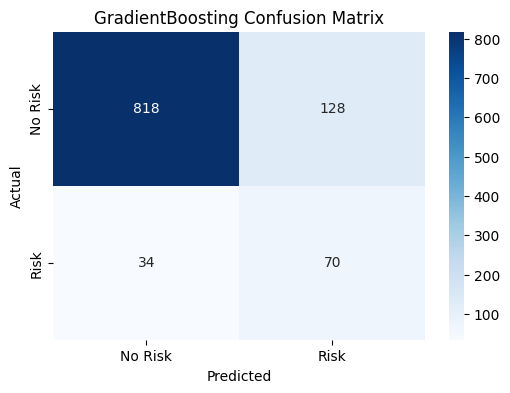


Classification Report for GradientBoosting:
              precision    recall  f1-score   support

       False       0.96      0.86      0.91       946
        True       0.35      0.67      0.46       104

    accuracy                           0.85      1050
   macro avg       0.66      0.77      0.69      1050
weighted avg       0.90      0.85      0.87      1050


Evaluating baseline XGBoost...


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8533
F1-score (True class): 0.4296
Recall (True class): 0.5577
ROC AUC: 0.8363


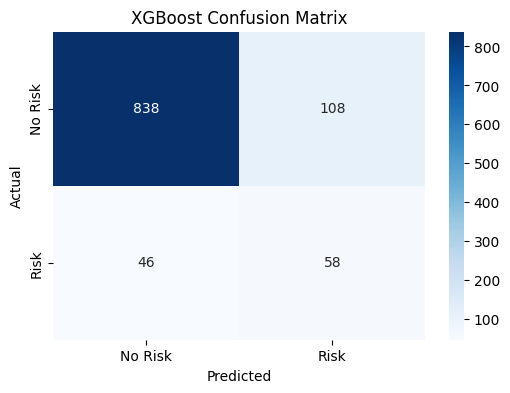


Classification Report for XGBoost:
              precision    recall  f1-score   support

       False       0.95      0.89      0.92       946
        True       0.35      0.56      0.43       104

    accuracy                           0.85      1050
   macro avg       0.65      0.72      0.67      1050
weighted avg       0.89      0.85      0.87      1050


Evaluating baseline CatBoost...

CatBoost model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8333
F1-score (True class): 0.4582
Recall (True class): 0.7115
ROC AUC: 0.8551


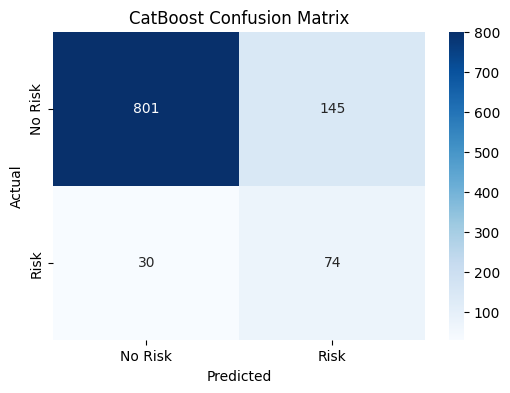


Classification Report for CatBoost:
              precision    recall  f1-score   support

       False       0.96      0.85      0.90       946
        True       0.34      0.71      0.46       104

    accuracy                           0.83      1050
   macro avg       0.65      0.78      0.68      1050
weighted avg       0.90      0.83      0.86      1050


Evaluating baseline LightGBM...
[LightGBM] [Info] Number of positive: 3750, number of negative: 4166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 7916, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473724 -> initscore=-0.105201
[LightGBM] [Info] Start training from score -0.105201

LightGBM model evaluation with threshold tuned 

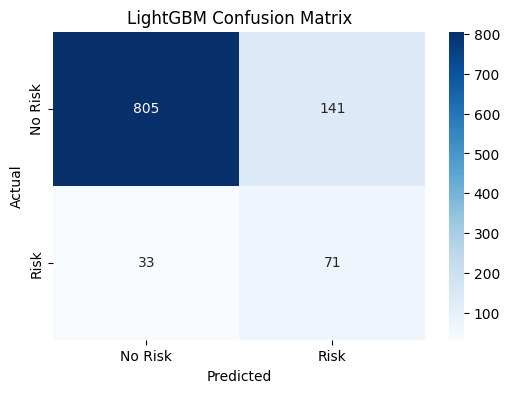


Classification Report for LightGBM:
              precision    recall  f1-score   support

       False       0.96      0.85      0.90       946
        True       0.33      0.68      0.45       104

    accuracy                           0.83      1050
   macro avg       0.65      0.77      0.68      1050
weighted avg       0.90      0.83      0.86      1050


RandomizedSearchCV tuning for GradientBoosting with recall scoring ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params for GradientBoosting: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}

Tuned GradientBoosting model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8610
F1-score (True class): 0.4786
Recall (True class): 0.6442
ROC AUC: 0.8655


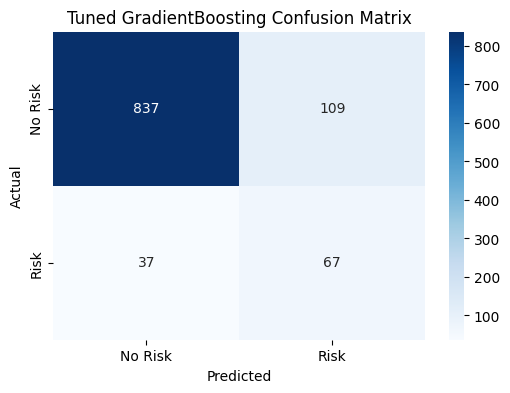


Classification Report for Tuned GradientBoosting:
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       946
        True       0.38      0.64      0.48       104

    accuracy                           0.86      1050
   macro avg       0.67      0.76      0.70      1050
weighted avg       0.90      0.86      0.88      1050


RandomizedSearchCV tuning for XGBoost with recall scoring ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\xgboost\core.py:158: UserWarning: [19:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\xgboost\core.py:158: UserWarning: [19:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

Tuned XGBoost model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8029
F1-score (True class): 0.3631
Recall (True class): 0.5673
ROC AUC: 0.8131


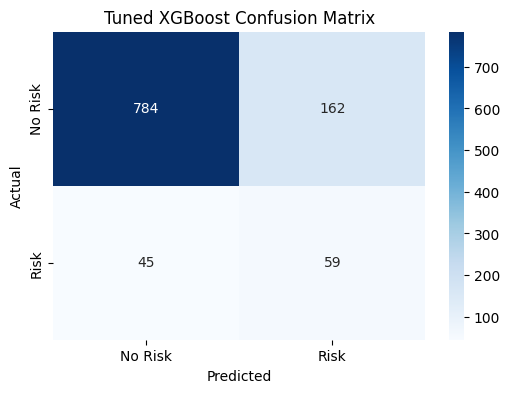


Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

       False       0.95      0.83      0.88       946
        True       0.27      0.57      0.36       104

    accuracy                           0.80      1050
   macro avg       0.61      0.70      0.62      1050
weighted avg       0.88      0.80      0.83      1050


RandomizedSearchCV tuning for CatBoost with recall scoring ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params for CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}

Tuned CatBoost model evaluation with threshold tuned for best F1-score:
Accuracy: 0.8590
F1-score (True class): 0.4825
Recall (True class): 0.6635
ROC AUC: 0.8697


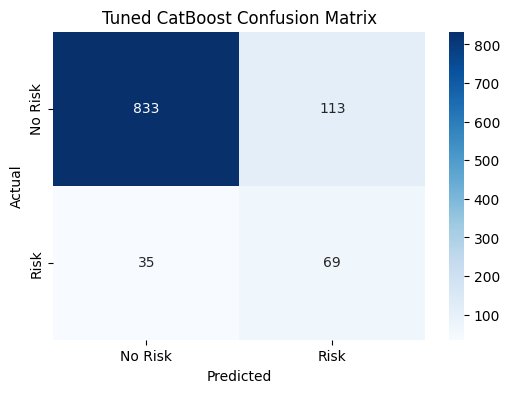


Classification Report for Tuned CatBoost:
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       946
        True       0.38      0.66      0.48       104

    accuracy                           0.86      1050
   macro avg       0.67      0.77      0.70      1050
weighted avg       0.90      0.86      0.88      1050


RandomizedSearchCV tuning for LightGBM with recall scoring ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 3750, number of negative: 4166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 7916, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473724 -> initscore=-0.105201
[LightGBM] [Info] Start training from score -0.105201
[LightGBM] [War

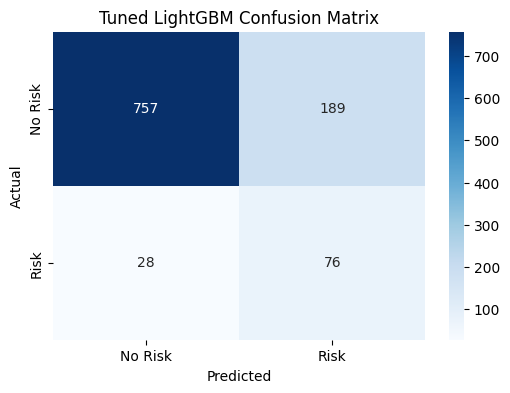


Classification Report for Tuned LightGBM:
              precision    recall  f1-score   support

       False       0.96      0.80      0.87       946
        True       0.29      0.73      0.41       104

    accuracy                           0.79      1050
   macro avg       0.63      0.77      0.64      1050
weighted avg       0.90      0.79      0.83      1050


Comparison of baseline and tuned models:
                    Model  accuracy  f1_score    recall   roc_auc
6          Tuned CatBoost  0.859048  0.482517  0.663462  0.869674
4  Tuned GradientBoosting  0.860952  0.478571  0.644231  0.865547
0        GradientBoosting  0.845714  0.463576  0.673077  0.862905
2                CatBoost  0.833333  0.458204  0.711538  0.855078
3                LightGBM  0.834286  0.449367  0.682692  0.855302
1                 XGBoost  0.853333  0.429630  0.557692  0.836305
7          Tuned LightGBM  0.793333  0.411924  0.730769  0.825815
5           Tuned XGBoost  0.802857  0.363077  0.567308  0.8

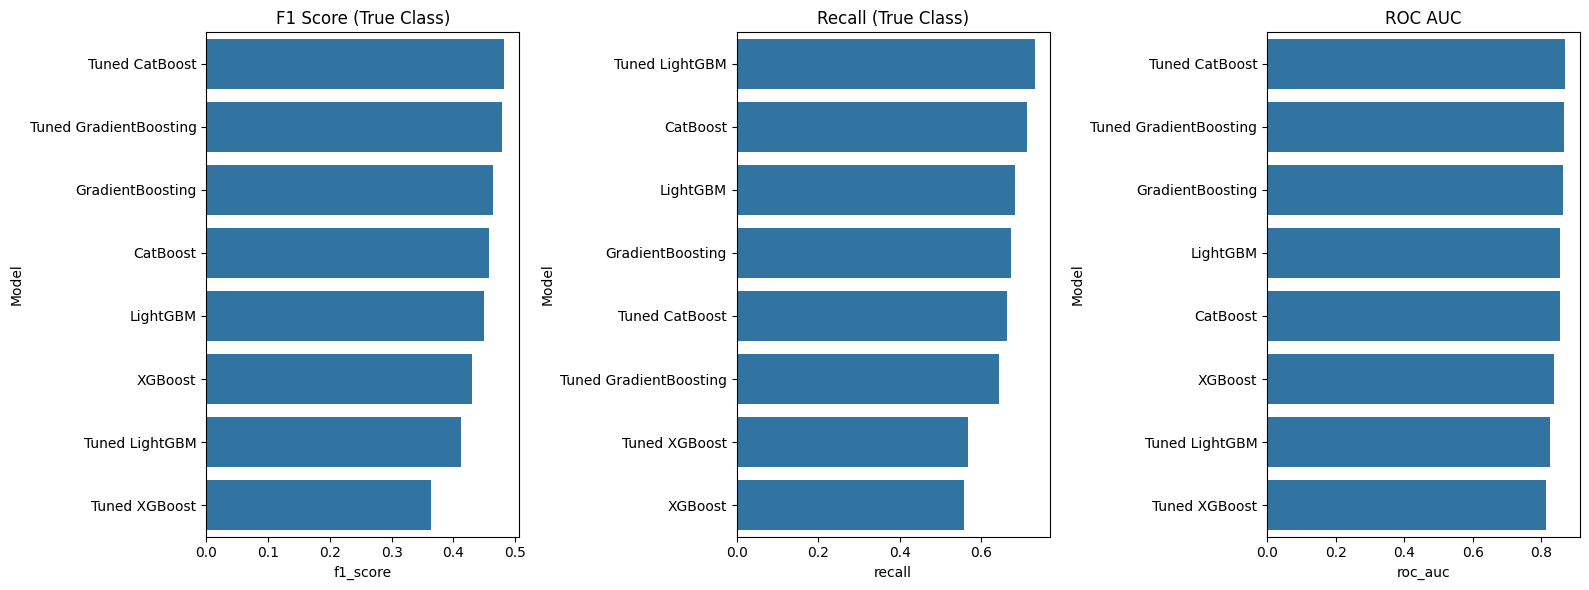


Best overall model based on F1-score: Tuned CatBoost with F1-score 0.4825

Detailed classification report of best model:
              precision    recall  f1-score      support
False          0.959677  0.880550  0.918412   946.000000
True           0.379121  0.663462  0.482517   104.000000
accuracy       0.859048  0.859048  0.859048     0.859048
macro avg      0.669399  0.772006  0.700465  1050.000000
weighted avg   0.902175  0.859048  0.875238  1050.000000

Process completed successfully!


In [6]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    f1_scores = 2*(precision*recall)/(precision+recall+1e-8)
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    y_pred = (y_pred_proba >= best_threshold).astype(int)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    rec = recall_score(y_val, y_pred)

    print(f"\n{model_name} model evaluation with threshold tuned for best F1-score:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (True class): {f1:.4f}")
    print(f"Recall (True class): {rec:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Risk', 'Risk'],
                yticklabels=['No Risk', 'Risk'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))

    return {
        'model': model,
        'best_threshold': best_threshold,
        'accuracy': acc,
        'f1_score': f1,
        'recall': rec,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y_val, y_pred, output_dict=True)
    }

base_models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42,
                                                   subsample=0.9,
                                                   n_estimators=100,
                                                   max_depth=3,
                                                   learning_rate=0.1),
    'XGBoost': XGBClassifier(random_state=42,
                             n_jobs=-1,
                             eval_metric='logloss',
                             scale_pos_weight=(len(y)-sum(y))/sum(y),
                             use_label_encoder=False),
    'CatBoost': CatBoostClassifier(random_state=42,
                                   verbose=0,
                                   auto_class_weights='Balanced'),
    'LightGBM': LGBMClassifier(random_state=42,
                               n_jobs=-1,
                               is_unbalance=True),
}

param_grids = {
    'GradientBoosting': {
        'n_estimators': [100, 150],
        'max_depth': [3, 4],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [200, 300],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.03, 0.1],
        'l2_leaf_reg': [3, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31]
    }
}

baseline_results = []
for name, model in base_models.items():
    print(f"\nEvaluating baseline {name}...")
    try:
        r = evaluate_model(model,
                           data_encodings['X_train_le'],
                           data_encodings['y_train_le'],
                           data_encodings['X_val_le'],
                           data_encodings['y_val_le'],
                           name)
        baseline_results.append({'Model': name, **r})
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")

baseline_df = pd.DataFrame(baseline_results)

tuned_results = []

for name, base_model in base_models.items():
    if name in param_grids:
        print(f"\nRandomizedSearchCV tuning for {name} with recall scoring ...")
        param_grid = param_grids[name]
        rs = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=6,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='recall',
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        rs.fit(data_encodings['X_train_le'], data_encodings['y_train_le'])
        best_model = rs.best_estimator_
        print(f"Best params for {name}: {rs.best_params_}")

        r = evaluate_model(best_model,
                           data_encodings['X_train_le'],
                           data_encodings['y_train_le'],
                           data_encodings['X_val_le'],
                           data_encodings['y_val_le'],
                           f"Tuned {name}")
        r['best_params'] = rs.best_params_
        tuned_results.append({'Model': f"Tuned {name}", **r})
    else:
        print(f"No tuning grid for model {name}, skipped tuning.")

tuned_df = pd.DataFrame(tuned_results)

comparison_df = pd.concat([baseline_df, tuned_df], ignore_index=True)

print("\nComparison of baseline and tuned models:")
print(comparison_df[['Model', 'accuracy', 'f1_score', 'recall', 'roc_auc']].sort_values('f1_score', ascending=False))

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='f1_score', y='Model', data=comparison_df.sort_values('f1_score', ascending=False))
plt.title('F1 Score (True Class)')

plt.subplot(1, 3, 2)
sns.barplot(x='recall', y='Model', data=comparison_df.sort_values('recall', ascending=False))
plt.title('Recall (True Class)')

plt.subplot(1, 3, 3)
sns.barplot(x='roc_auc', y='Model', data=comparison_df.sort_values('roc_auc', ascending=False))
plt.title('ROC AUC')

plt.tight_layout()
plt.show()

best_model_info = comparison_df.loc[comparison_df['f1_score'].idxmax()]
print(f"\nBest overall model based on F1-score: {best_model_info['Model']} with F1-score {best_model_info['f1_score']:.4f}")

print("\nDetailed classification report of best model:")
print(pd.DataFrame(best_model_info['classification_report']).transpose())

print("\nProcess completed successfully!")